In [484]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt

sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu

In [520]:
MASK_OUT = -1
# compute mse per cluster and then average over batch or file
def mse_batch(labels, preds):
    return np.mean(np.mean(np.square(labels - preds), axis=1))

def mse_batch_no_pad(preds, labels):
    sum = 0
    count = 0
    for clus_idx, clus_labels in enumerate(labels):
        cut_padding = (clus_labels != MASK_OUT)
        if len(clus_labels[cut_padding]) > 0:
            sum += np.mean(np.square(clus_labels[cut_padding] - preds[clus_idx][cut_padding]))
            count += 1

    return sum / count

# slice and plot loss
def plot_batch_loss(all_loss, batch_low=None, batch_high=None):
    batch_high = len(all_loss) if batch_high == None else batch_high
    batch_low = 0 if batch_low == None else batch_low
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(batch_low, batch_high), all_loss[batch_low:batch_high])
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.show()

def plot_epoch_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def get_history(file_name):
    return np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/" + file_name, allow_pickle=True)

def plot_clus_pred_acc(clus_idx, preds, labels, verbose=False, point_low=None, point_high=None):
    if point_low == None and point_high == None:
        point_low = 0
        point_high = len(labels[clus_idx][cut_padding]) + 10
    cut_padding = labels[clus_idx] != MASK_OUT
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
    plt.scatter(np.arange(point_low, point_high), preds[clus_idx][point_low:point_high], label="preds")
    plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
    plt.xlabel("point")
    plt.ylabel("EM frac")
    plt.title("Cluster " + str(clus_idx))
    plt.legend()
    plt.show()
    if verbose:
        print("cluster" + str(clus_idx) + ", cells " + str(point_low) + " to " + point_high)
        print("predicted EM frac:")
        print(preds[clus_idx][point_low:point_high].flatten())
        print("truth:")
        print(labels[clus_idx][point_low:point_high].flatten())

def plot_clus_preds_acc(clus_idxs, preds, labels, epochs, verbose=False, point_low=None, point_high=None):
    calc_range = False
    if point_low == None and point_high == None:
        calc_range = True
    
    for clus_idx in clus_idxs:
        cut_padding = labels[clus_idx] != MASK_OUT
        if calc_range:
            point_low = 0
            point_high = min(len(labels[clus_idx][cut_padding]) + 10, len(labels[clus_idx]))
        fig = plt.figure(figsize=(15,3))
        fig.patch.set_facecolor('white')
        plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
        for epoch in epochs:
            plt.scatter(np.arange(point_low, point_high), preds[epoch][clus_idx][point_low:point_high], label="epoch " + str(epoch))
        plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
        plt.xlabel("point")
        plt.ylabel("EM frac")
        plt.title("Cluster " + str(clus_idx) + " preds")
        plt.legend()
        plt.show()

    # plot hist of all clusters
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    cut_padding_all_clus = labels != MASK_OUT
    data = [labels[cut_padding_all_clus].flatten()]
    labels = ["truth"]
    for epoch in epochs:
        data.append(preds[epoch][cut_padding_all_clus].flatten())
        labels.append("epoch " + str(epoch))

    pu.plot_overlay_hist(data, 75, "All clusters predictions", "EM frac", "frequency", labels)

def plot_all_clus_acc(history):
    cut_padding = (history["labels"] != -1)
    all_labels = history["labels"][cut_padding].flatten()
    all_preds = history["preds"][cut_padding].flatten()
    pu.plot_overlay_hist([all_labels, all_preds], 100, "All clusters", "EM frac", "frequency", ["truth", "preds"])
    
def pointwise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss) / np.sum(mask) # flattens data
    return out

def batch_wise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss, axis=1) / np.sum(mask, axis=1) # flattens data
    return np.mean(out)

In [590]:
def plot_preds_vs_truth(file_name, epoch):
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name

    preds = np.load(dir + "/tests/preds_" + str(epoch) + ".npy")
    labels = np.load(dir + "/tests/labels.npy")
    cut_unmasked = labels != MASK_OUT

    print("pointwise mae:", np.mean(np.abs(preds[cut_unmasked] - labels[cut_unmasked])))
    fig = plt.figure(figsize=(8, 6.5))
    fig.patch.set_facecolor('white')
    plt.hist2d(labels[cut_unmasked], preds[cut_unmasked], (50,50), range=((0,1),(0,1)), cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())
    plt.xlabel("EM frac truth")
    plt.ylabel("EM frac pred")
    plt.colorbar(label="frequency")
    plt.show()

In [591]:
def train_summary_stats(file_name, num_epochs, clusters=[]):
    # load all train data
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name 
    loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]

    preds = []
    mse_batch_loss = []
    pointwise_loss = []
    labels = np.load(dir + "/tests/labels.npy")
    print("labels shape:", labels.shape)
    for epoch in range(num_epochs):
        preds.append(np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))
        mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))
        pointwise_loss.append(pointwise_loss_func(labels, preds[epoch]))
    
    # plot train and val loss
    plot_epoch_loss(loss, val_loss)

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    print("test (batchwise)", mse_batch_loss)
    print("test (pointwise)", pointwise_loss)

    # plot clusters preds/labels over epochs
    epochs = [0]
    if num_epochs != 1:
        epochs.append(num_epochs - 1)

    plot_clus_preds_acc(clusters, preds, labels, epochs)

    pu.plot_hist(labels[labels != -1], 50, "Truth EM frac", "Truth EM frac", "frequency")

labels shape: (18000, 1053, 1)


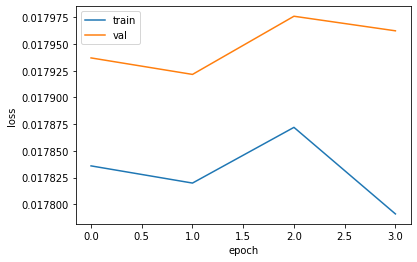

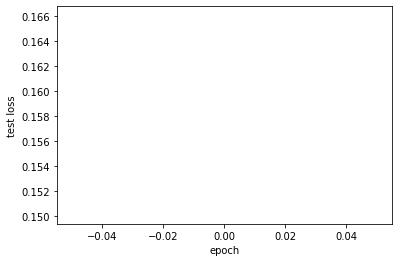

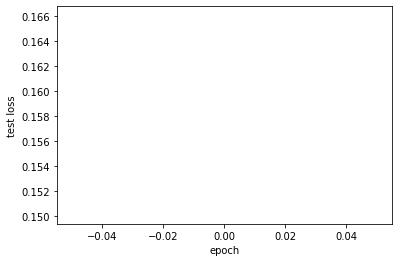

test (batchwise) [0.15808724664739246]
test (pointwise) [0.13441054029732924]


<Figure size 432x288 with 0 Axes>

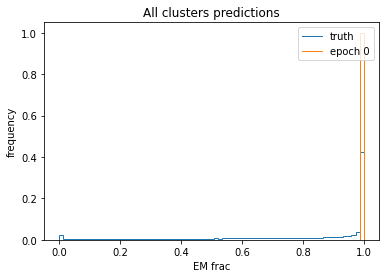

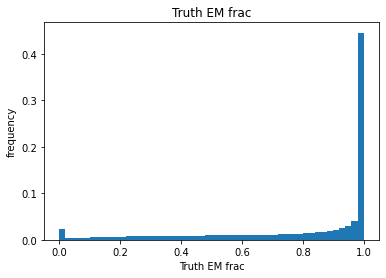

In [597]:
train_summary_stats("_4/beta_N_1053", 1)

pointwise mae: 0.21912433301391218


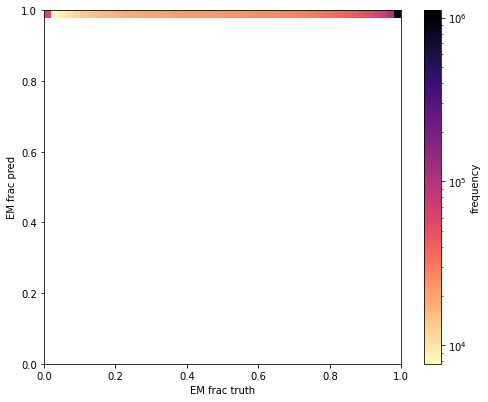

In [595]:
num_epoch = 5
epochs = [0]#, 10, 49]
for epoch in epochs:
    plot_preds_vs_truth("_4/beta_N_1053", epoch)

In [607]:
events = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_4/train/pi0_14_pipm_13_14_len_6000_i_8_cartesian_event_grouped.npz")
print(events["Y"].shape)

tot_cells = 0
num_events = events["Y"].shape[0]

for event in events["Y"]:
    tot_cells += len(event[event != -1])

print("mean num cells:", tot_cells / num_events)

(3946, 1047, 1)
mean num cells: 139.71768879878357
